In [1]:
#1 先导入所需要的程序包
import datetime
import numpy as np
import pandas as pd
import time
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy
import pickle
from tqdm import tqdm # 进度条工具

# 定义类'参数分析'
class ParameterAnalysis(object):
    
    # 定义函数中不同的变量
    def __init__(self):
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'f16629492d6b6f4040b2546262782c78'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          
                     end_date='2025-02-20',         # 回测的结束日期
                     frequency='minute',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[]                # 回测中每个变量的备选参数值
                     ):
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        self.params_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        self.params_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_returns = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 当运行回测开始后，如果没有全部运行完全的话：
        if hasattr(self, 'backtest'):
            for i in tqdm(range(total_backtest_num), desc="运行回测", unit="backtest"):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = self.params_df.iloc[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                bt = self.backtest(params)
                all_returns[i] = bt.daily_net_liquidation
                all_evaluations[i] = bt.statistic()
                
        # 记录结束时间
        end = time.time() 
        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))),
        # 对应修改类内部对应
        self.returns = all_returns
        self.evaluations = all_evaluations
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def write_backtest_data(self, file_name='results.pkl'):
        # # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'evaluations':self.evaluations,
                   'evaluations_df':self.evaluations_df,
                   'params_df':self.params_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.evaluations = results['evaluations']
        self.evaluations_df = results['evaluations_df']
        self.params_df = results['params_df']
        
    def plot_returns(self):
        # 计算每个策略的累计收益率
        cumulative_returns = {}
        dates = {}  # 保存每个策略的日期
        for key, data in self.returns.items():
            net_liquidation = [entry['net_liquidation'] for entry in data]
            dates[key] = [entry['date'] for entry in data]  # 提取日期
            
            # 计算每日收益率
            daily_returns = [(net_liquidation[i] - net_liquidation[i-1]) / net_liquidation[i-1] if i > 0 else 0 for i in range(len(net_liquidation))]
            
            # 计算累计收益率
            cumulative_returns[key] = [0]  # 初始化累计收益率，第一个点为0
            for i in range(1, len(daily_returns)):
                cumulative_return = (1 + daily_returns[i]) * (1 + cumulative_returns[key][-1]) - 1
                cumulative_returns[key].append(cumulative_return)

        # 创建图形
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        
        # 绘制每个策略的累计收益率
        for key, cumulative_return_values in cumulative_returns.items():
            ax.plot(range(len(cumulative_return_values)), cumulative_return_values, label=key)

        # 设置 benchmark 曲线并标记
        benchmark_returns = [(self.benchmark_returns[i] - self.benchmark_returns[i-1]) / self.benchmark_returns[i-1] if i > 0 else 0 for i in range(len(self.benchmark_returns))]
        benchmark_cumulative = [0]  # 初始累计收益率为0
        for i in range(1, len(benchmark_returns)):
            cumulative_benchmark = (1 + benchmark_returns[i]) * (1 + benchmark_cumulative[-1]) - 1
            benchmark_cumulative.append(cumulative_benchmark)

        ax.plot(range(len(benchmark_cumulative)), benchmark_cumulative, label='benchmark', c='k', linestyle='--')

        # 设置 x 轴刻度
        ticks = [int(x) for x in np.linspace(0, len(next(iter(dates.values()))) - 1, 11)]  # 使用第一个策略的日期长度
        plt.xticks(ticks, [dates[next(iter(dates))][i] for i in ticks])  # 使用第一个策略的日期

        # 设置图例样式
        ax.legend(loc=2, fontsize=10)
        # 设置 y 轴标签样式
        ax.set_ylabel('Cumulative Returns', fontsize=20)
        # 设置 y 轴刻度格式为百分比
        ax.set_yticklabels([str(x*100) + '% ' for x in ax.get_yticks()])
        # 设置图表标题
        ax.set_title("Strategy's Performances with Different Parameters", fontsize=21)
        # 设置 x 轴的显示范围
        ax.set_xlim(0, len(next(iter(cumulative_returns.values()))))
        # 显示图表
        plt.show()
    # 超额收益率图    
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))



In [2]:
import sys
sys.path.append('..')

from BacktestApp import BacktestApp
from StructureReserve import StructureReserve

class StructureReserveBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file=config_file, **kwargs)
        self.angle = kwargs["params"]["angle"]
        self.dispear_angle = kwargs["params"]["dispear_angle"]
        
    def on_bar_update(self, contract, bars, has_new_bar):
        if has_new_bar:
            structure = StructureReserve(angle=self.angle, dispear_angle=self.dispear_angle)
            structure.data = bars
            structure.has_prepare_data = True
            structure.update(contract, bars, self.pm)
            
def pre_process_bar_callback(bars):
    data_process = StructureReserve()
    return data_process.prepare_data(bars)
    
class StructureReserveAnalysis(ParameterAnalysis):
    def backtest(self, params):
        ba = StructureReserveBacktestApp(config_file="../config_backtest.yml", clientId=18, debug=True, params=params)
        try:
            ba.minutes_backtest("20250221", "200 D", pre_process_bar_callback=pre_process_bar_callback)
        finally:
            ba.ib.disconnect()
            ba.ib = None
        return ba
        
pa = StructureReserveAnalysis()

In [3]:
pa.run_backtest(
                param_names = ['angle', 'dispear_angle'],
                param_values = [np.arange(0.005, 0.03 + 0.005, 0.005), np.arange(0.005, 0.01 + 0.005, 0.005)]
                )
pa.write_backtest_data()

运行回测: 100%|██████████| 12/12 [2:28:40<00:00, 743.39s/backtest] 

【回测完成】总用时：8920秒(即2.48小时)。


In [4]:
#4 数据读取
pa.read_backtest_data('results.pkl')

In [5]:
#6 查看回测结果指标
pa.evaluations_df

,angle,dispear_angle,cumulative_pnl,max_drawdown,sharpe_ratio,volatility,daily_return
0,0.005,0.005,73309.590528,0.022765,1.312988,0.043164,0.000364
1,0.005,0.010,87170.216272,0.021211,1.661060,0.044284,0.000431
2,0.010,0.005,88850.204504,0.017442,1.757772,0.042652,0.000436
3,0.010,0.010,103965.479000,0.016694,2.109206,0.044132,0.000508
4,0.015,0.005,90588.632304,0.017154,1.860057,0.041688,0.000447
5,0.015,0.010,99133.022768,0.016647,2.033321,0.043319,0.000488
6,0.020,0.005,118732.681120,0.012172,2.763981,0.039739,0.000575
7,0.020,0.010,128088.719512,0.013740,2.931324,0.041291,0.000619
8,0.025,0.005,106285.977880,0.010700,2.520359,0.037852,0.000517
9,0.025,0.010,114488.875096,0.011984,2.657560,0.039666,0.000557


C:\Users\Jagger\AppData\Local\Temp\ipykernel_36404\2020938513.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(x*100) + '% ' for x in ax.get_yticks()])


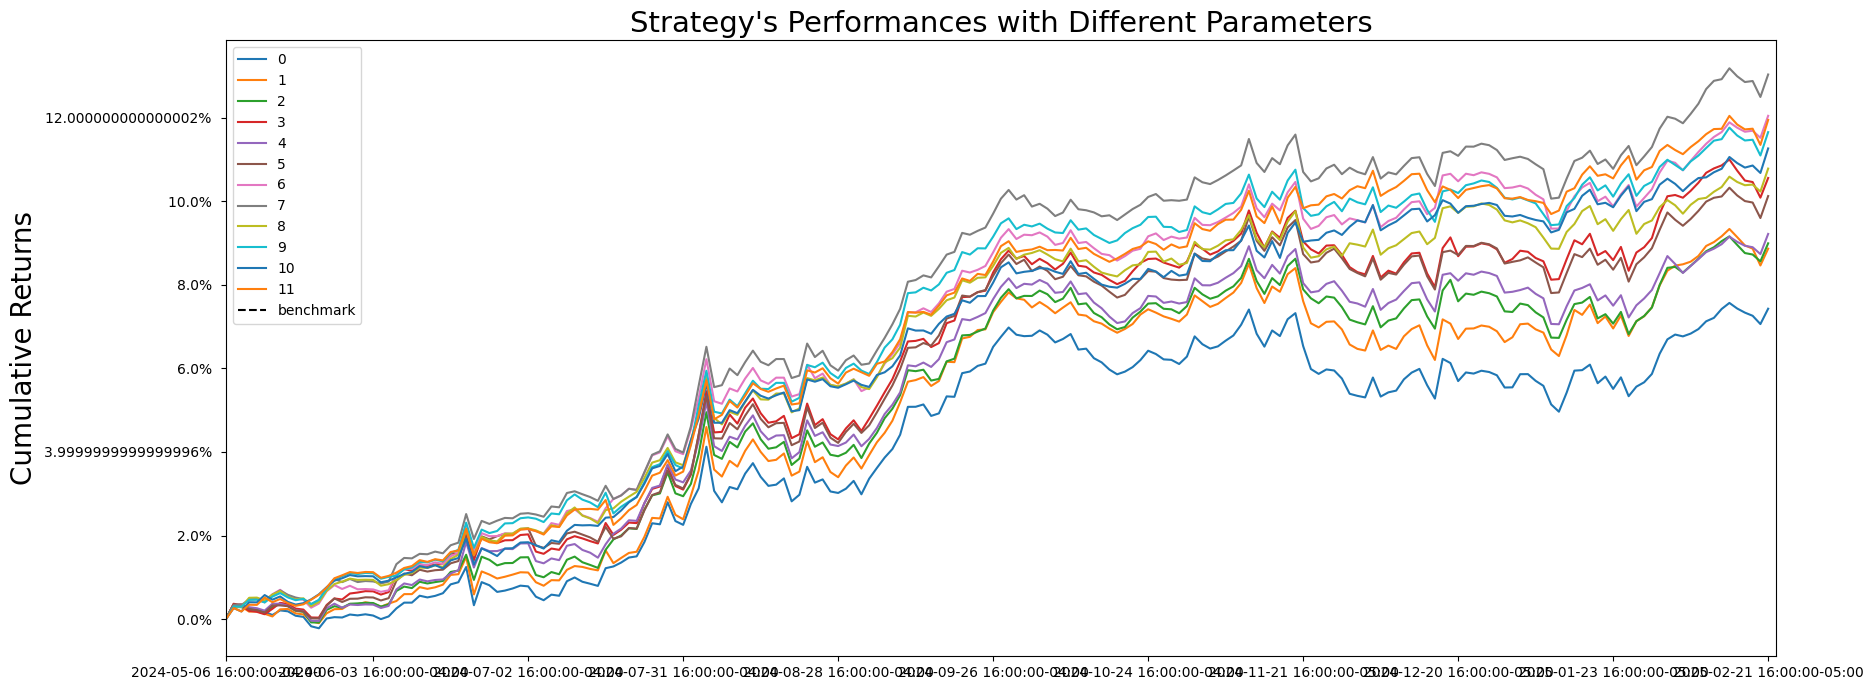

In [6]:
def plot_returns(self):
    # 计算每个策略的累计收益率
    cumulative_returns = {}
    dates = {}  # 保存每个策略的日期
    for key, data in self.returns.items():
        net_liquidation = [entry['net_liquidation'] for entry in data]
        dates[key] = [entry['date'] for entry in data]  # 提取日期
        
        # 计算每日收益率
        daily_returns = [(net_liquidation[i] - net_liquidation[i-1]) / net_liquidation[i-1] if i > 0 else 0 for i in range(len(net_liquidation))]
        
        # 计算累计收益率
        cumulative_returns[key] = [0]  # 初始化累计收益率，第一个点为0
        for i in range(1, len(daily_returns)):
            cumulative_return = (1 + daily_returns[i]) * (1 + cumulative_returns[key][-1]) - 1
            cumulative_returns[key].append(cumulative_return)

    # 创建图形
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111)
    
    # 绘制每个策略的累计收益率
    for key, cumulative_return_values in cumulative_returns.items():
        ax.plot(range(len(cumulative_return_values)), cumulative_return_values, label=key)

    # 设置 benchmark 曲线并标记
    benchmark_returns = [(self.benchmark_returns[i] - self.benchmark_returns[i-1]) / self.benchmark_returns[i-1] if i > 0 else 0 for i in range(len(self.benchmark_returns))]
    benchmark_cumulative = [0]  # 初始累计收益率为0
    for i in range(1, len(benchmark_returns)):
        cumulative_benchmark = (1 + benchmark_returns[i]) * (1 + benchmark_cumulative[-1]) - 1
        benchmark_cumulative.append(cumulative_benchmark)

    ax.plot(range(len(benchmark_cumulative)), benchmark_cumulative, label='benchmark', c='k', linestyle='--')

    # 设置 x 轴刻度
    ticks = [int(x) for x in np.linspace(0, len(next(iter(dates.values()))) - 1, 11)]  # 使用第一个策略的日期长度
    plt.xticks(ticks, [dates[next(iter(dates))][i] for i in ticks])  # 使用第一个策略的日期

    # 设置图例样式
    ax.legend(loc=2, fontsize=10)
    # 设置 y 轴标签样式
    ax.set_ylabel('Cumulative Returns', fontsize=20)
    # 设置 y 轴刻度格式为百分比
    ax.set_yticklabels([str(x*100) + '% ' for x in ax.get_yticks()])
    # 设置图表标题
    ax.set_title("Strategy's Performances with Different Parameters", fontsize=21)
    # 设置 x 轴的显示范围
    ax.set_xlim(0, len(next(iter(cumulative_returns.values()))))
    # 显示图表
    plt.show()

plot_returns(pa)

AttributeError: 'StructureReserveAnalysis' object has no attribute 'excess_returns'

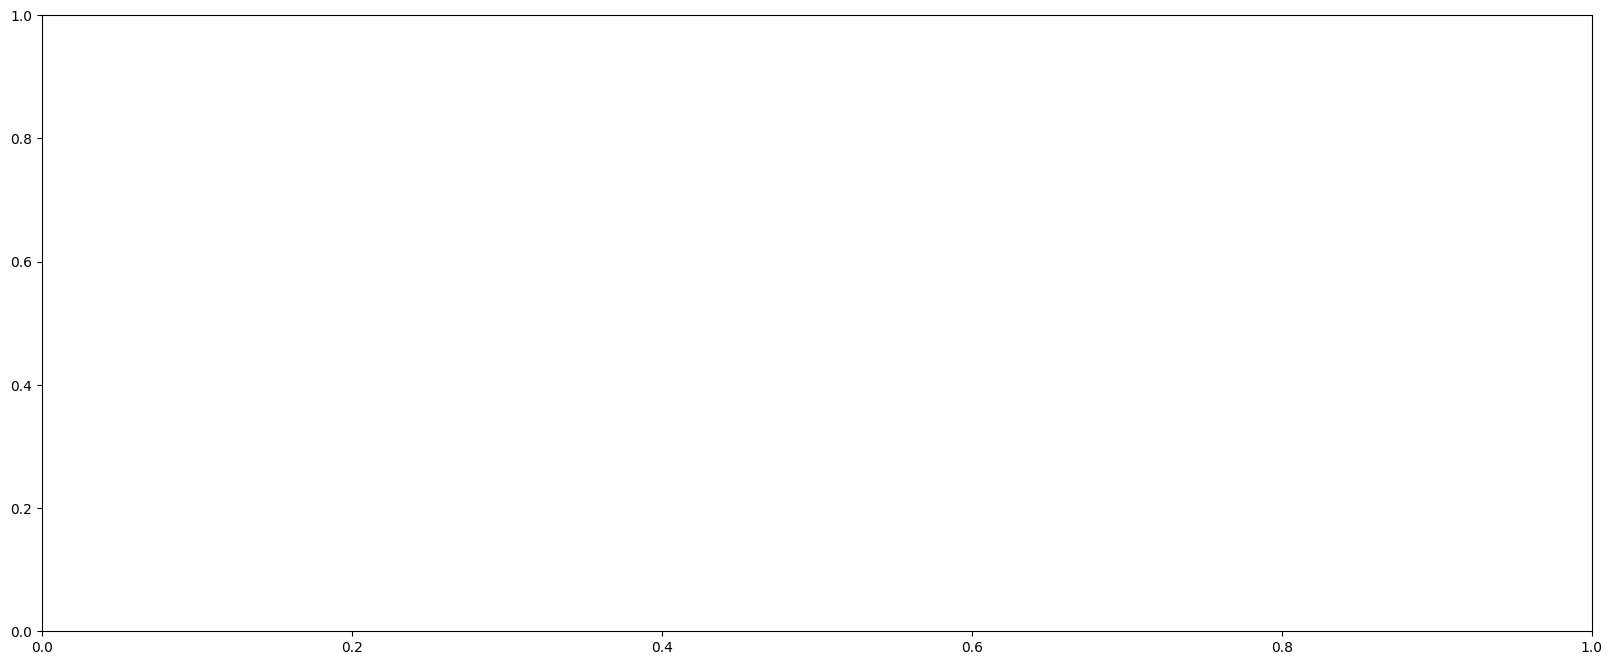

In [7]:
#8 超额收益率图    
pa.plot_excess_returns()

In [ ]:
#9 log回报率图    
pa.plot_log_returns()

In [ ]:
#10 超额收益率的 log 图
pa.plot_log_excess_returns()

In [ ]:
#11 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
# get_eval4_bar(self, sort_by=[])
pa.get_eval4_bar()

In [ ]:
#12 年化回报和最大回撤，正负双色显示
# get_eval(self, sort_by=[])
pa.get_eval()

In [ ]:
#13 超额收益的年化回报和最大回撤
# 加入新的benchmark后超额收益和
# get_excess_eval(self, sort_by=[])
pa.get_excess_eval()

In [ ]:
# test 测试最后bar图中的sort_by对应内容
param_names=['abc','x_y_z']
param_values=[['a','b','c'], [1,2]]
param_combinations = list(itertools.product(*param_values))
to_run_df = pd.DataFrame(param_combinations)
to_run_df.columns = param_names
# to_run_df.ix[1].to_dict()
to_run_df

# sort_by = ['abc']
sort_by = ['abc', 'x_y_z']
# sort_by = ['x_y_z']
# sort_by = ['x_y_z','abc']
sorted_params = to_run_df
for by in sort_by:
    sorted_params = sorted_params.sort(by)
indices = sorted_params.index
sorted_params